# Session 4: Working with Astronomical Data

In [72]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Part 1: Reading and Writing Various Data Formats

 #### Astronomers often work with data in formats like 
 #### FITS (images/spectra), 
 #### CSV (catalogs), 
 #### and HDF5 (not covered in this notebook).

### Example 1: Reading a FITS Image

In [73]:
# Load a sample FITS file (you can download one or use your own)
# For demonstration, we'll simulate FITS data here:
data = np.random.normal(loc=1000, scale=50, size=(100, 100))

# Save to FITS for demo purposes
hdu = fits.PrimaryHDU(data)
hdu.writeto('files/demo_image.fits', overwrite=True)

# Now read it back
with fits.open('files/demo_image.fits') as hdul:
    image_data = hdul[0].data

print(f"Image shape: {image_data.shape}")

Image shape: (100, 100)


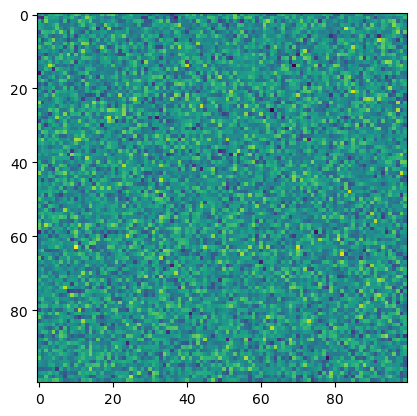

In [74]:
plt.imshow(image_data)

### A note on HDU lists:

HDUList — a list-like object that contains one or more Header/Data Units (HDUs).

Each HDU has two parts:

- Header: metadata (like object name, telescope, exposure time, WCS info)
- Data: the actual image array or table (e.g., 2D image, 1D spectrum, catalog)

In [46]:
print(hdul.info())

Filename: files/demo_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (100, 100)   float64   
None


This FITS file has one HDU (index 0), containing a 100×100 image.

### Example 2: Reading a CSV Catalog

In [75]:
# Simulate a simple catalog
catalog_data = {
    'ObjectID': [1, 2, 3],
    'RA': [10.684, 56.75, 150.1],   # degrees
    'DEC': [41.269, -20.5, 2.1],    # degrees
    'Magnitude': [5.2, 12.3, 7.8]
}

catalog = pd.DataFrame(catalog_data)
catalog.to_csv('files/demo_catalog.csv', index=False)

# Read it back
catalog_loaded = pd.read_csv('files/demo_catalog.csv')
print(catalog_loaded)

   ObjectID       RA     DEC  Magnitude
0         1   10.684  41.269        5.2
1         2   56.750 -20.500       12.3
2         3  150.100   2.100        7.8


## Part 2: Astronomical Databases and Catalogs

Astronomers use online databases to query catalogs (e.g., Gaia, SDSS, SIMBAD).

We’ll use astroquery (optional install) to query SIMBAD:

In [76]:
from astroquery.simbad import Simbad

# Query object information from SIMBAD into an astropy table
result = Simbad.query_object("M31")  # Andromeda Galaxy
print(result)

MAIN_ID      RA          DEC      RA_PREC ... COO_WAVELENGTH     COO_BIBCODE     SCRIPT_NUMBER_ID
          "h:m:s"      "d:m:s"            ...                                                    
------- ------------ ------------ ------- ... -------------- ------------------- ----------------
  M  31 00 42 44.330 +41 16 07.50       7 ...              I 2006AJ....131.1163S                1


### Query images:

**Astroquery** itself typically queries catalogs (tables) or metadata (positions, fluxes, identifiers) from services like SIMBAD, Vizier, or SkyView.

To download actual FITS images, you can use astroquery.skyview or astroquery.sdss, or MAST for HST/JWST.

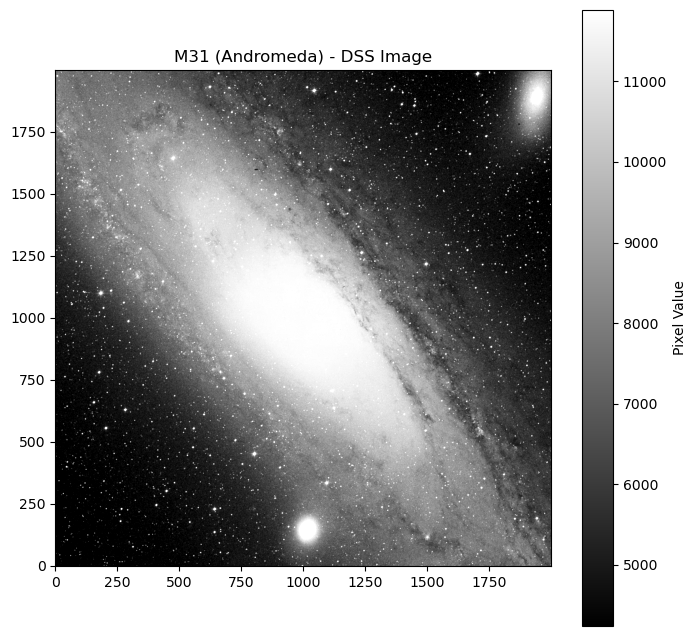

In [32]:
from astroquery.skyview import SkyView
from astropy.io import fits
import matplotlib.pyplot as plt

# A list of possible targets:
# the Lagoon Nebula (M8)
# the Trifid Nebula (M20)
# the Eagle Nebula (M16)
# the Omega Nebula (M17)

# Query a FITS image of M31 from DSS (Digitized Sky Survey)
image_list = SkyView.get_images(position='M31', survey='DSS', pixels=2000)

# image_list is a list of HDULists, we'll use the first one
hdu = image_list[0][0]  # PrimaryHDU

# Extract data
image_data = hdu.data

# Visualize
plt.figure(figsize=(8,8))
plt.imshow(image_data, 
           cmap='gray', 
           origin='lower',
           # norm=LogNorm())
           vmin=np.percentile(image_data, 5), 
           vmax=np.percentile(image_data, 99))
plt.colorbar(label='Pixel Value')
plt.title('M31 (Andromeda) - DSS Image')
plt.show()


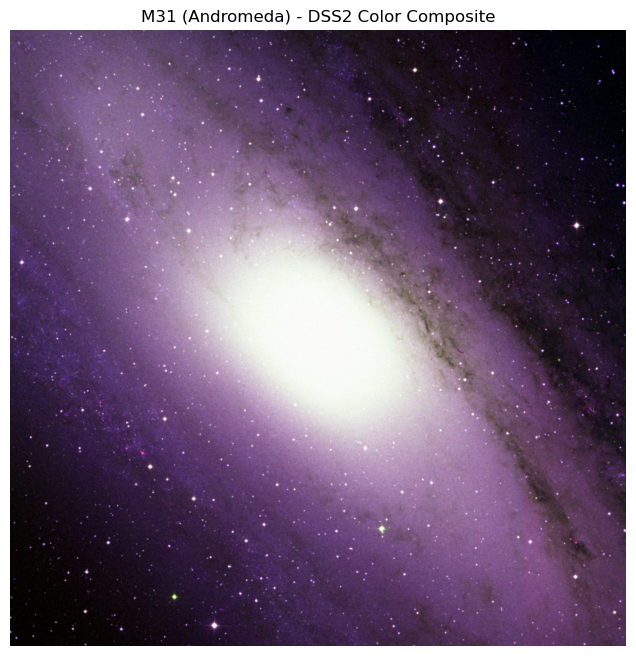

In [31]:
from astroquery.skyview import SkyView
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Request DSS2 images in Blue, Red, and Infrared bands
surveys = ['DSS2 Blue', 'DSS2 Red', 'DSS2 IR']
image_list = SkyView.get_images(position='M31', survey=surveys, pixels=2000)

# Extract data for each band
blue_data = image_list[0][0].data
red_data = image_list[1][0].data
ir_data = image_list[2][0].data  # Used as Green proxy (since DSS lacks a green filter)

# Normalize each image to [0,1] for RGB display
def normalize_image(data, stretch_percentiles=(1, 99)):
    vmin, vmax = np.percentile(data, stretch_percentiles)
    data_clipped = np.clip(data, vmin, vmax)
    normed = (data_clipped - vmin) / (vmax - vmin)
    return normed

blue_norm = normalize_image(blue_data)
red_norm = normalize_image(red_data)
green_norm = normalize_image(ir_data)  # DSS lacks green, so use IR as green proxy

# Stack into RGB image
rgb_image = np.dstack((red_norm, green_norm, blue_norm))

# Display the RGB composite
plt.figure(figsize=(8,8))
plt.imshow(rgb_image, origin='lower')
plt.title('M31 (Andromeda) - DSS2 Color Composite')
plt.axis('off')

## Part 3: Matplotlib Basics

#### Example: Sky positions of catalog objects

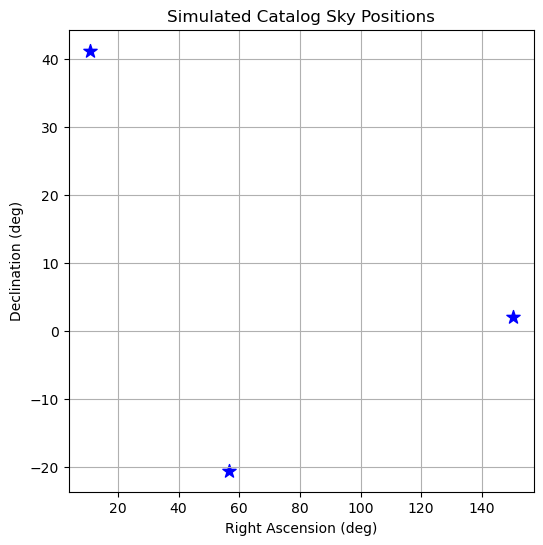

In [77]:
plt.figure(figsize=(6,6))
plt.scatter(catalog_loaded['RA'], 
            catalog_loaded['DEC'], 
            s=100, 
            color='blue', 
            marker='*')

plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title('Simulated Catalog Sky Positions')
plt.grid(True)

### Example: Working with GAIA

In [78]:
# Import necessary packages
from astroquery.gaia import Gaia

# Query (ADQL) a small region around M45 (Pleiades cluster)
query = """
SELECT TOP 10000
    source_id, ra, dec, phot_g_mean_mag, pmra, pmdec
FROM gaiadr3.gaia_source
WHERE CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', 56.75, 24.12, 0.5)
)=1
"""
job = Gaia.launch_job_async(query)
gaia_table = job.get_results()
gaia_df = gaia_table.to_pandas()

# Quick look
print(gaia_df.head())


INFO: Query finished. [astroquery.utils.tap.core]
           SOURCE_ID         ra        dec  phot_g_mean_mag      pmra  \
0  66521037596508928  57.092457  23.953635        19.956541  0.867109   
1  66521041893494016  57.105145  23.949852        21.004105       NaN   
2  66504235685418496  57.149536  23.793427        19.919777 -0.454721   
3  66504235685418624  57.152047  23.793791        19.353968 -6.162098   
4  66504274339388672  57.153497  23.804365        19.272957  6.349439   

       pmdec  
0  -0.344517  
1        NaN  
2  -0.210334  
3  -7.842337  
4 -11.641154  


# Notes:

✅ **What is SQL?**

SQL (Structured Query Language) is a standard language used to query, retrieve, and manipulate data from databases.

Used in almost every field: business, science, websites, apps.

Basic SQL can:

- Select specific columns (SELECT ra, dec FROM stars)

- Filter rows (WHERE magnitude < 10)

- Sort data (ORDER BY magnitude)

- Aggregate (counts, averages, etc.)

SQL is like asking a question to a big spreadsheet stored in a database.

✅ **What is ADQL?**

ADQL (Astronomical Data Query Language) is a special version of SQL designed for astronomical data.

It's based on SQL but adds:

- Sky coordinates handling (RA, DEC)

- Geometric searches (circles, polygons on the sky)

- Uses ICRS coordinates, cone searches, etc.

ADQL is used to query astronomical catalogs like Gaia, SDSS, Pan-STARRS.

### Visualizing the star positions

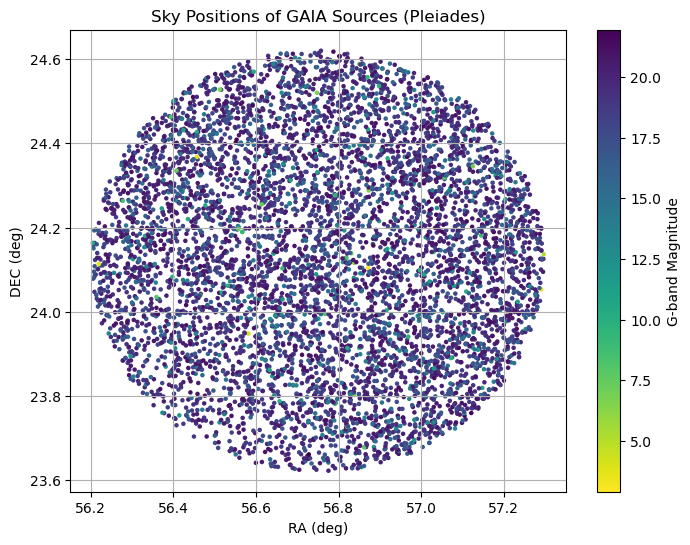

In [79]:
plt.figure(figsize=(8,6))
plt.scatter(gaia_df['ra'], 
            gaia_df['dec'], 
            s=5, 
            c=gaia_df['phot_g_mean_mag'], 
            cmap='viridis_r')
plt.colorbar(label='G-band Magnitude')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.title('Sky Positions of GAIA Sources (Pleiades)')
plt.grid(True)
plt.show()

### Visualizing Proper motion vectors

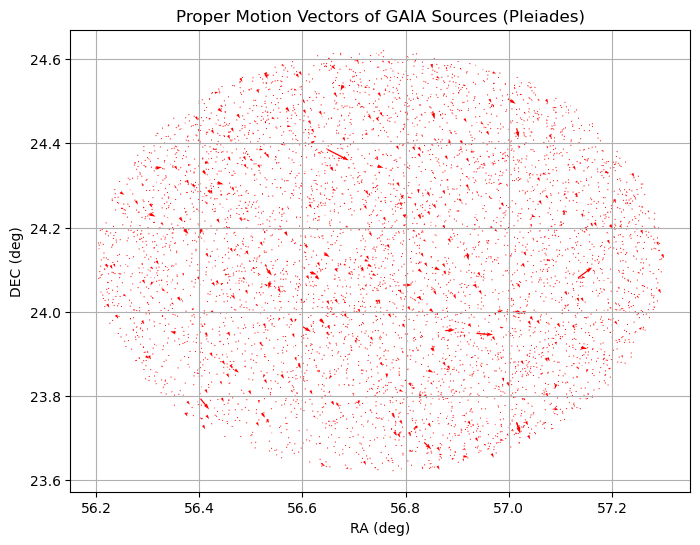

In [80]:
plt.figure(figsize=(8,6))
plt.quiver(gaia_df['ra'], 
           gaia_df['dec'], 
           gaia_df['pmra'], 
           gaia_df['pmdec'], 
           angles='xy', 
           scale_units='xy', 
           scale=5000, 
           width=0.002, 
           color='red')

plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.title('Proper Motion Vectors of GAIA Sources (Pleiades)')
plt.grid(True)
plt.show()

✅ **Preliminary Conclusion from Proper Motion Plot**

📝 What you're observing:

- Most stars show small or negligible proper motion vectors.
- A few stars show large, noticeable proper motions (longer arrows).

🔭 Preliminary Interpretation:

Most stars in the plot are distant background stars:

- Small proper motion means they are far away from us.
- Their apparent motion on the sky is tiny over time.

Stars with large proper motions are likely closer to us:

- Large proper motion usually indicates nearby stars.
- Their movement is more noticeable because of their proximity.

Possible cluster members:

- If some stars have similar proper motion direction & magnitude, they might be members of the same cluster (e.g., Pleiades).
- Field/background stars will have random, scattered proper motions.

### Magnitude Distributions

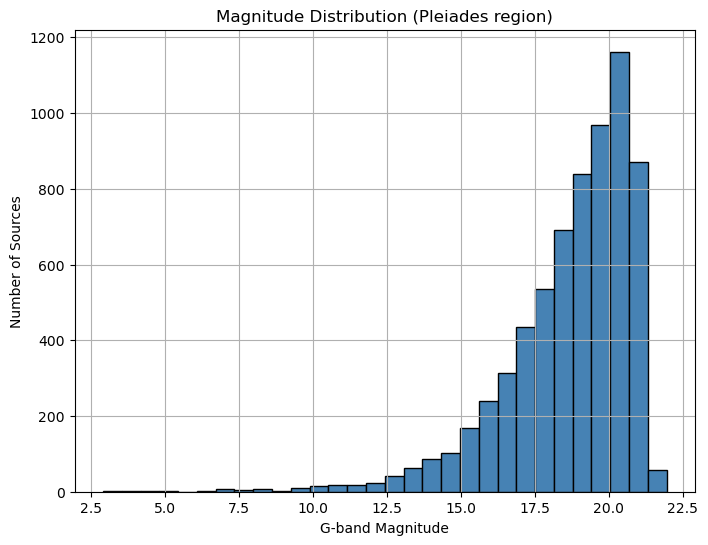

In [81]:
plt.figure(figsize=(8,6))
plt.hist(gaia_df['phot_g_mean_mag'], 
         bins=30, 
         color='steelblue', 
         edgecolor='black')
plt.xlabel('G-band Magnitude')
plt.ylabel('Number of Sources')
plt.title('Magnitude Distribution (Pleiades region)')
plt.grid(True)
plt.show()

### Density Map

In [53]:
print(f"RA range: {gaia_df['ra'].min():.3f} to {gaia_df['ra'].max():.3f}")
print(f"DEC range: {gaia_df['dec'].min():.3f} to {gaia_df['dec'].max():.3f}")

RA range: 56.205 to 57.297
DEC range: 23.623 to 24.620


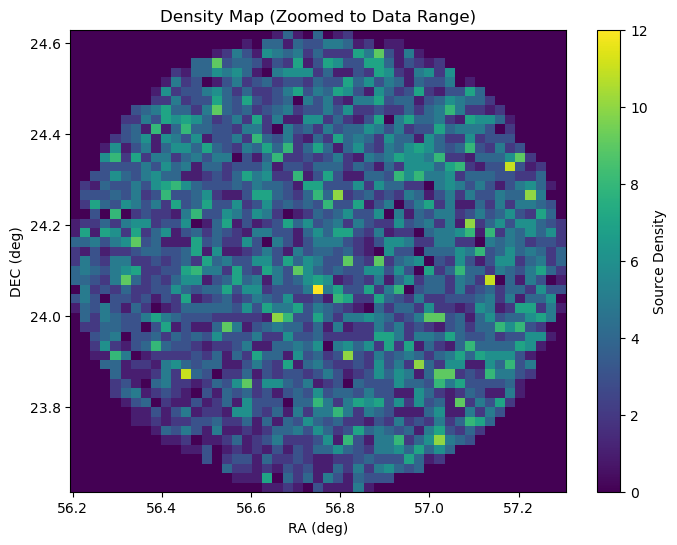

In [61]:
ra_range = (gaia_df['ra'].min() - 0.01, gaia_df['ra'].max() + 0.01)
dec_range = (gaia_df['dec'].min() - 0.01, gaia_df['dec'].max() + 0.01)

ra_bins = np.linspace(ra_range[0], ra_range[1], 50)
dec_bins = np.linspace(dec_range[0], dec_range[1], 50)

density, xedges, yedges = np.histogram2d(gaia_df['ra'], 
                                         gaia_df['dec'], 
                                         bins=[ra_bins, dec_bins])

plt.figure(figsize=(8,6))
plt.imshow(density.T, 
           origin='lower', 
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap='viridis', 
           aspect='auto')

# norm=LogNorm(vmin=0.1, vmax=density.max()),

plt.colorbar(label='Source Density')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.title('Density Map (Zoomed to Data Range)')
plt.show()


# Homework 4:

📊 **Problem 1: Load and Plot a FITS Image**

1. A file at address files/simple_starfield.fits will be provided.
2. Load the FITS image.
3. Display it with a grayscale colormap.
4. Add a colorbar and axis labels.

🔹 Hint: Use astropy.io.fits and imshow.

📊 **Problem 2: Load and Plot a CSV file**

1. A file at address files/gaia_sample.csv will be provided.
2. Load the CSV image.
3. Display the star positions in columns "ra" and "dec" with plt.scatter.
4. For the plot above, add a colorbar that sets the color based on column "phot_g_mean_mag".
4. Display the distribution of values in column "phot_g_mean_mag" with a plt.hist plot.

🔹 Hint: Use pd.read_csv and plt.scatter and plt.hist.

🌌 **Problem 3: Simulate and Plot a Catalog**

1. Simulate a catalog of 100 stars:
- RA: uniform between 0 and 360 degrees.
- DEC: uniform between -90 and +90 degrees.
- Magnitude: uniform between 10 and 20.
2. Save it to a CSV file named simulated_catalog.csv.
3. Load it back and plot a scatter plot of RA vs DEC.
4. Use marker size or color to indicate magnitude (brighter sources larger or different color).

🔹 Hint: Fainter stars have larger magnitude numbers (invert for size/color).

🔭 **Problem 4: Query SIMBAD for Real Object Data**

1. Use astroquery to query Betelgeuse and Vega.
2. Print out:
- Object Name
- RA (degrees)
- DEC (degrees)
- Any available flux/magnitude in visible bands.
3. Plot both objects on a small sky map (RA vs DEC scatter plot).
🔹 Hint: Install astroquery: pip install astroquery.

🖼️ **Problem 5: Write a Reusable Image Display Function**

Write a function display_fits_image(filename, scale='linear', vmin=None, vmax=None).
The function should:

1. Load the FITS file.
2. Plot the image with:
- Linear scale (imshow)
- Logarithmic scale if scale='log'.
- Use vmin and vmax for contrast adjustment.
- Add colorbar and title.
3. Test it on simple_starfield.fits with different scales and vmin/vmax values.

🔹 Hint: Use LogNorm for log scaling.